# Alfred FPL BI Library — Local Validation

This notebook exercises the full BI stack: data access → analytics → visualization → executor.

**Prerequisites:** Run `python scripts/sync.py --bootstrap` and `--gw <current>` to populate Supabase.

## Sections
1. **Setup** — imports, Supabase connection
2. **Data Catalog** — ground truth columns from each enriched view + raw tables
3. **Column Cross-Reference** — compare actual columns vs FALLBACK_SCHEMAS
4. **Analytics** — rank, filter, rolling stats
5. **Visualization** — bar, line, heatmap charts
6. **Executor** — sandboxed code execution (simulate LLM)
7. **Safety** — blocked operations

In [1]:
# Setup: load env and connect
import sys
sys.path.insert(0, '../src')

from dotenv import load_dotenv
load_dotenv('../.env')

from alfred_fpl.bi.data_access import QuerySpec, Filter, fetch_df, fetch_enriched
from alfred_fpl.bi.analytics import (
    add_rolling_mean, compute_form_trend, compute_differentials,
    compute_fixture_difficulty, compute_price_velocity, rank_by,
)
from alfred_fpl.bi.viz import render_line, render_bar, render_heatmap, render_comparison
from alfred_fpl.bi.schemas import validate_df
from alfred_fpl.bi.executor import execute

from IPython.display import Image, display
import pandas as pd

print('BI library loaded successfully.')

BI library loaded successfully.


C:\Projects\fpltools\venv\Lib\site-packages\pandera\_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


## 2. Data Catalog — Enriched Views

Ground truth: what columns does each enriched view actually return from Supabase?
This is what `df_<table>` will look like inside the executor.

In [2]:
# Data Catalog: enriched views — the views the LLM's code will operate on
catalog = {}

enriched_views = {
    'players': {'order_by': 'total_points', 'ascending': False, 'limit': 5},
    'squad': {'limit': 15},  # Needs manager_id filter in real use
    'player_form': {'limit': 5},
    'standings': {'limit': 5},
    'fixtures': {'order_by': 'gameweek', 'limit': 5},
}

for view_name, kwargs in enriched_views.items():
    print(f'\n{"="*60}')
    print(f'ENRICHED VIEW: {view_name}')
    print(f'{"="*60}')
    try:
        df = fetch_enriched(view_name, **kwargs)
        catalog[view_name] = df
        print(f'Shape: {df.shape}')
        print(f'\nColumns ({len(df.columns)}):')
        print(f'  {df.columns.tolist()}')
        print(f'\nDtypes:')
        for col, dtype in df.dtypes.items():
            null_pct = df[col].isnull().mean() * 100
            print(f'  {col:30s} {str(dtype):15s} ({null_pct:.0f}% null)')
        if not df.empty:
            print(f'\nSample (first 3 rows):')
            display(df.head(3))
    except Exception as e:
        print(f'  ERROR: {e}')
        catalog[view_name] = pd.DataFrame()


ENRICHED VIEW: players
Shape: (5, 21)

Columns (21):
  ['id', 'fpl_id', 'web_name', 'first_name', 'second_name', 'team_id', 'position_id', 'price', 'total_points', 'selected_by_percent', 'status', 'news', 'form', 'points_per_game', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'team', 'position']

Dtypes:
  id                             object          (0% null)
  fpl_id                         int64           (0% null)
  web_name                       object          (0% null)
  first_name                     object          (0% null)
  second_name                    object          (0% null)
  team_id                        object          (0% null)
  position_id                    object          (0% null)
  price                          float64         (0% null)
  total_points                   int64           (0% null)
  selected_by_percent            float64         (0% null)
  status                         object          (0% null)
  news                    

,id,fpl_id,web_name,first_name,second_name,team_id,position_id,price,total_points,selected_by_percent,...,news,form,points_per_game,minutes,goals_scored,assists,clean_sheets,bonus,team,position
0,094a2dc5-5419-4a10-9662-a9406ae85125,430,Haaland,Erling,Haaland,b92b7b52-cce8-4c07-97c0-ae90479b849b,a55b0e3c-e1b1-4730-863b-8f8a5393b65a,14.9,187,67.7,...,Knee injury - 75% chance of playing,5.5,7.2,2143,22,6,10,34,MCI,FWD
1,dcf28eaf-67df-43e2-baee-dab9cfe0a2c1,82,Semenyo,Antoine,Semenyo,b92b7b52-cce8-4c07-97c0-ae90479b849b,12cac268-721a-46b0-a2e7-a566ebb97a50,8.0,153,50.4,...,,7.8,6.1,2250,13,6,7,17,MCI,MID
2,3abb9d0e-8e1f-48ae-b5b5-68aaa2d84abf,21,Rice,Declan,Rice,67325c45-9f49-4bf4-89ac-14983bc9f4b9,12cac268-721a-46b0-a2e7-a566ebb97a50,7.6,148,35.0,...,,4.6,5.7,2235,4,8,12,21,ARS,MID



ENRICHED VIEW: squad
Shape: (15, 13)

Columns (13):
  ['id', 'manager_id', 'manager_name', 'gameweek', 'player_id', 'slot', 'multiplier', 'is_captain', 'is_vice_captain', 'player_name', 'player_price', 'player_form', 'player_total_points']

Dtypes:
  id                             object          (0% null)
  manager_id                     int64           (0% null)
  manager_name                   object          (0% null)
  gameweek                       int64           (0% null)
  player_id                      object          (0% null)
  slot                           int64           (0% null)
  multiplier                     int64           (0% null)
  is_captain                     bool            (0% null)
  is_vice_captain                bool            (0% null)
  player_name                    object          (0% null)
  player_price                   float64         (0% null)
  player_form                    float64         (0% null)
  player_total_points            int64    

,id,manager_id,manager_name,gameweek,player_id,slot,multiplier,is_captain,is_vice_captain,player_name,player_price,player_form,player_total_points
0,69076e57-babd-41f9-88a2-c979951efa0b,6578679,Vignesh Jeyaraman,26,8ce35787-c94d-4fe7-b1e6-b42246150e11,1,1,False,False,Roefs,4.9,2.5,107
1,1facd4c5-d4cb-44fb-9b8b-07a222400e1e,6578679,Vignesh Jeyaraman,26,cf9b4ab4-8a74-4fcf-b871-bea42087e282,2,1,False,False,J.Timber,6.4,3.0,124
2,67dba0dc-7785-455c-815d-720ffc6dbc87,6578679,Vignesh Jeyaraman,26,cbd8f270-1957-434b-a191-9ce3eb4200c2,3,1,False,False,Thiaw,5.0,3.2,97



ENRICHED VIEW: player_form
Shape: (5, 24)

Columns (24):
  ['id', 'player_id', 'gameweek', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'total_points', 'in_dreamteam', 'value', 'player_name', 'team_id']

Dtypes:
  id                             object          (0% null)
  player_id                      object          (0% null)
  gameweek                       int64           (0% null)
  minutes                        int64           (0% null)
  goals_scored                   int64           (0% null)
  assists                        int64           (0% null)
  clean_sheets                   int64           (0% null)
  goals_conceded                 int64           (0% null)
  saves                          int64           (0% null)
  bonus                          int64           (0% null)


,id,player_id,gameweek,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,...,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam,value,player_name,team_id
0,6bbfbdf6-2209-4d82-ae20-c987abb2a759,410f12ac-9ab4-4c70-8a2e-5592dd5165eb,26,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.00,0,False,None,Aznou,3d8ff8e6-d3ea-455a-a61c-4a77885a9454
1,8942f3c4-a003-4f60-9f06-008203d2503b,ee14c192-99c1-460f-98c5-6d7f0e14b105,26,90,0,0,0,1,2,0,...,2.0,0.0,0.0,0.0,1.34,2,False,None,Raya,67325c45-9f49-4bf4-89ac-14983bc9f4b9
2,e9f05fe2-92b4-4213-a2c2-bf34fc1e7d4b,7090a560-c439-48aa-8b23-f78bc71e6a96,26,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.00,0,False,None,Arrizabalaga,67325c45-9f49-4bf4-89ac-14983bc9f4b9



ENRICHED VIEW: standings
Shape: (5, 11)

Columns (11):
  ['id', 'league_id', 'league_name', 'gameweek', 'manager_id', 'manager_name', 'team_name', 'rank', 'last_rank', 'total_points', 'event_points']

Dtypes:
  id                             object          (0% null)
  league_id                      int64           (0% null)
  league_name                    object          (0% null)
  gameweek                       int64           (0% null)
  manager_id                     int64           (0% null)
  manager_name                   object          (0% null)
  team_name                      object          (0% null)
  rank                           int64           (0% null)
  last_rank                      int64           (0% null)
  total_points                   int64           (0% null)
  event_points                   int64           (0% null)

Sample (first 3 rows):


,id,league_id,league_name,gameweek,manager_id,manager_name,team_name,rank,last_rank,total_points,event_points
0,ed658627-573a-45ae-b929-3007a28fa735,1486488,Abe Yaar,26,5324901,Krishanth Kanakarajah,PaTTa PaTTi XI,1,2,1503,69
1,cb2fd7c3-9f94-463f-a4bc-0ded3f7cc2fb,1486488,Abe Yaar,26,1670867,Afdal Basheer,Hopeless FC,2,1,1497,58
2,8572fb1f-7347-41ab-ad90-84178b1f053a,1486488,Abe Yaar,26,2901215,Rishwanth R,RishX1,3,3,1475,51



ENRICHED VIEW: fixtures
Shape: (5, 13)

Columns (13):
  ['id', 'fpl_id', 'gameweek', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'kickoff_time', 'finished', 'home_difficulty', 'away_difficulty', 'home_team', 'away_team']

Dtypes:
  id                             object          (0% null)
  fpl_id                         int64           (0% null)
  gameweek                       int64           (0% null)
  home_team_id                   object          (0% null)
  away_team_id                   object          (0% null)
  home_score                     int64           (0% null)
  away_score                     int64           (0% null)
  kickoff_time                   object          (0% null)
  finished                       bool            (0% null)
  home_difficulty                int64           (0% null)
  away_difficulty                int64           (0% null)
  home_team                      object          (0% null)
  away_team                      object      

,id,fpl_id,gameweek,home_team_id,away_team_id,home_score,away_score,kickoff_time,finished,home_difficulty,away_difficulty,home_team,away_team
0,ef741c7e-45ae-4db8-a14a-c0b576c6a6d4,1,1,3c0801d2-5611-4ddd-8526-598f4edef3ba,72eb7751-8342-432d-9f50-f84aa6802191,4,2,2025-08-15T19:00:00+00:00,True,3,4,LIV,BOU
1,1f704a9f-413c-45dc-981a-23c1957809ef,2,1,cffb19a4-cf18-49ce-b104-e6b7b8666774,e7b15cef-50e1-4d14-969d-f4b691c8e1d6,0,0,2025-08-16T11:30:00+00:00,True,3,4,AVL,NEW
2,b3c48846-fe87-4cf2-9dcf-331f2752396e,3,1,c23ae067-0139-431e-b77d-dca314a4ac93,200d2076-4b82-48d4-8db4-16b119483758,1,1,2025-08-16T14:00:00+00:00,True,2,3,BHA,FUL


In [ ]:
# Data Catalog: raw tables — used in ANALYZE steps alongside enriched views
raw_tables = {
    'player_gameweeks': {'limit': 5, 'order_by': 'gameweek', 'ascending': False},
    'player_snapshots': {'limit': 5, 'order_by': 'gameweek', 'ascending': False},
    'transfers': {'limit': 5},
    'manager_seasons': {'limit': 5},
    'league_standings': {'limit': 5},
}

for table, kwargs in raw_tables.items():
    print(f'\n{"="*60}')
    print(f'RAW TABLE: {table}')
    print(f'{"="*60}')
    try:
        spec = QuerySpec(table=table, **kwargs)
        df = fetch_df(spec)
        catalog[table] = df
        print(f'Shape: {df.shape}')
        print(f'\nColumns ({len(df.columns)}):')
        print(f'  {df.columns.tolist()}')
        if not df.empty:
            print(f'\nDtypes:')
            for col, dtype in df.dtypes.items():
                null_pct = df[col].isnull().mean() * 100
                print(f'  {col:30s} {str(dtype):15s} ({null_pct:.0f}% null)')
            display(df.head(3))
    except Exception as e:
        print(f'  ERROR: {e}')

## 3. Column Cross-Reference

Compare actual Supabase columns against our FALLBACK_SCHEMAS (what the LLM thinks columns are).
Mismatches here = the LLM writes wrong column names in ANALYZE code.

In [3]:
# Column cross-reference: actual Supabase columns vs FALLBACK_SCHEMAS
import re
from alfred_fpl.domain.schema import FALLBACK_SCHEMAS

def extract_column_names(schema_str: str) -> set[str]:
    """Extract column names from FALLBACK_SCHEMAS format like 'col_name (type, desc)'."""
    return {m.group(1) for m in re.finditer(r'(\w+)\s*\(', schema_str)}

print('COLUMN CROSS-REFERENCE: Actual vs FALLBACK_SCHEMAS')
print('='*70)

# Map enriched view names to their base tables for schema comparison
view_to_base = {
    'players': 'players',
    'squad': 'squads',
    'player_form': 'player_gameweeks',
    'standings': 'league_standings',
    'fixtures': 'fixtures',
}

mismatches_found = False
for view_name, df in catalog.items():
    if df.empty:
        continue
    
    actual_cols = set(df.columns)
    
    # Find matching FALLBACK_SCHEMA
    schema_table = view_to_base.get(view_name, view_name)
    if schema_table not in FALLBACK_SCHEMAS:
        print(f'\n{view_name}: no FALLBACK_SCHEMA for base table "{schema_table}"')
        continue
    
    schema_cols = extract_column_names(FALLBACK_SCHEMAS[schema_table])
    
    in_actual_not_schema = actual_cols - schema_cols
    in_schema_not_actual = schema_cols - actual_cols
    
    if in_actual_not_schema or in_schema_not_actual:
        mismatches_found = True
        print(f'\n--- {view_name} (base: {schema_table}) ---')
        if in_actual_not_schema:
            print(f'  In Supabase but NOT in schema: {sorted(in_actual_not_schema)}')
            print(f'    (These are enriched columns from JOINs — expected for enriched views)')
        if in_schema_not_actual:
            print(f'  In schema but NOT in Supabase: {sorted(in_schema_not_actual)}')
            print(f'    WARNING: LLM will try to use these columns but they may not exist!')
    else:
        print(f'\n--- {view_name} (base: {schema_table}) --- OK (exact match)')

if not mismatches_found:
    print('\nAll columns match perfectly!')

COLUMN CROSS-REFERENCE: Actual vs FALLBACK_SCHEMAS

--- players (base: players) ---
  In Supabase but NOT in schema: ['position', 'team']
    (These are enriched columns from JOINs — expected for enriched views)

--- squad (base: squads) ---
  In Supabase but NOT in schema: ['player_form', 'player_name', 'player_price', 'player_total_points']
    (These are enriched columns from JOINs — expected for enriched views)

--- player_form (base: player_gameweeks) ---
  In Supabase but NOT in schema: ['player_name', 'team_id']
    (These are enriched columns from JOINs — expected for enriched views)

--- standings (base: league_standings) --- OK (exact match)

--- fixtures (base: fixtures) ---
  In Supabase but NOT in schema: ['away_team', 'home_team']
    (These are enriched columns from JOINs — expected for enriched views)


In [5]:
# Fetch enriched players view for remaining sections
df_players = fetch_enriched(
    'players',
    order_by='total_points',
    ascending=False,
    limit=20,
)
print(f'Fetched {len(df_players)} players')
df_players[['web_name', 'team', 'position', 'price', 'total_points', 'form']].head(10)

Fetched 20 players


,web_name,team,position,price,total_points,form
0,Haaland,MCI,FWD,14.9,187,5.5
1,Semenyo,MCI,MID,8.0,153,7.8
2,Rice,ARS,MID,7.6,148,4.6
3,B.Fernandes,MUN,MID,9.8,143,6.8
4,Gabriel,ARS,DEF,7.1,142,4.4
5,Bruno G.,NEW,MID,7.0,134,3.5
6,Thiago,BRE,FWD,7.0,133,2.8
7,João Pedro,CHE,FWD,7.7,132,10.0
8,Rogers,AVL,MID,7.6,125,5.5
9,Guéhi,MCI,DEF,5.2,124,4.8


## 4. Analytics — Rank Top Midfielders by Form

In [7]:
# Filter midfielders and rank by form
mids = df_players[df_players.get('position', pd.Series()) == 'MID'].copy()
if not mids.empty:
    top_mids = rank_by(mids, 'form', n=10)
    top_mids[['rank', 'web_name', 'team', 'price', 'form', 'total_points']]
else:
    print('No midfielders found — check that enriched join includes position')
    # Fallback: rank all players
    top = rank_by(df_players, 'total_points', n=10)
    top[['rank', 'web_name', 'price', 'total_points', 'form']]

## 5. Visualization — Bar Chart of Top Scorers

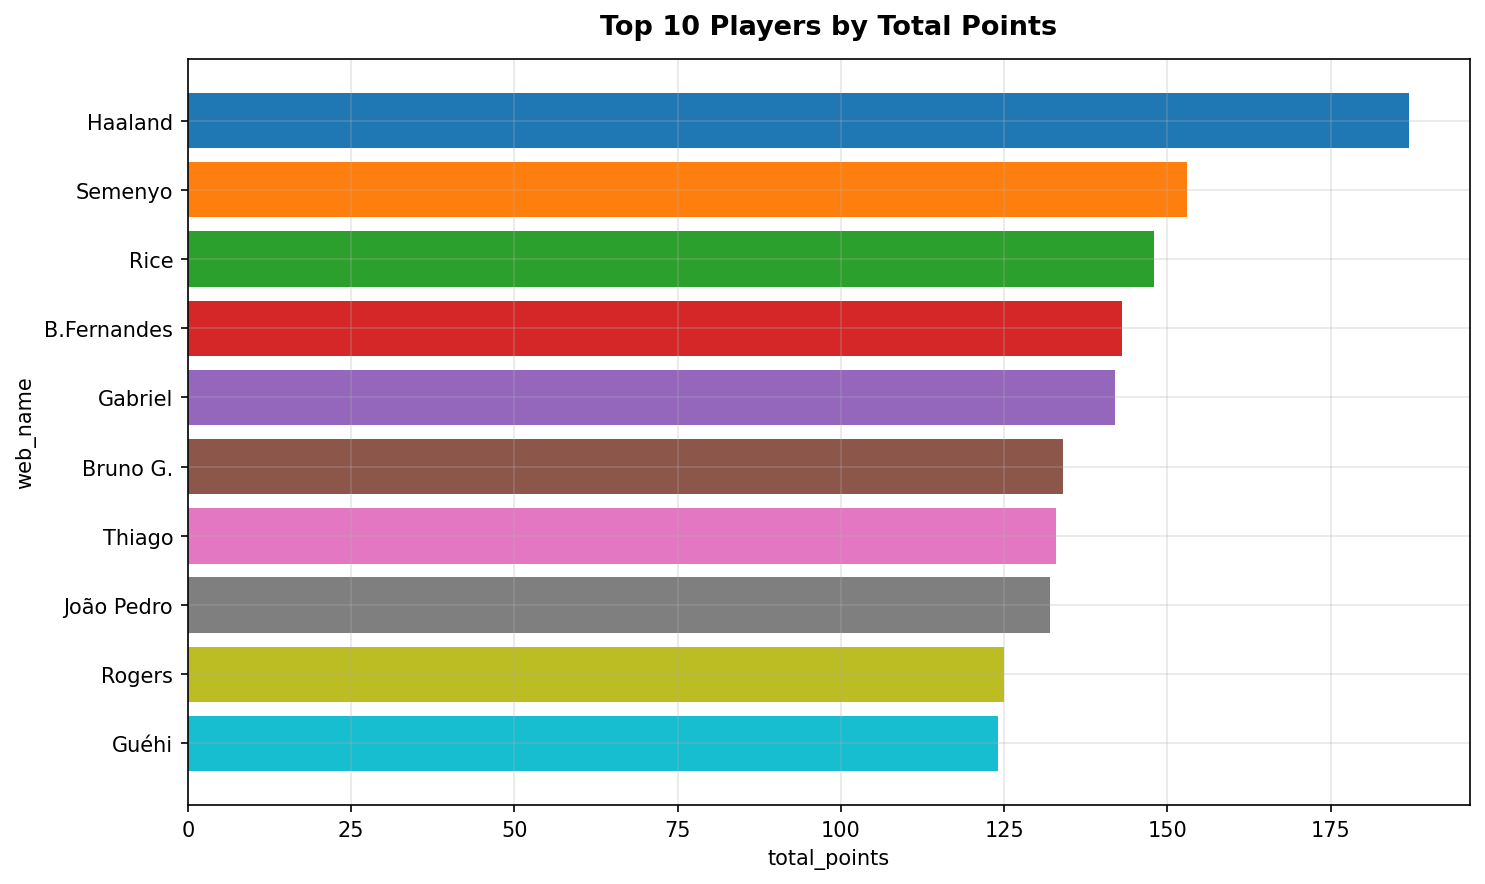

In [8]:
top_10 = rank_by(df_players, 'total_points', n=10)
chart_path = render_bar(
    top_10, x='web_name', y='total_points',
    title='Top 10 Players by Total Points',
    horizontal=True,
)
display(Image(filename=str(chart_path)))

## 5b. Form Trend — Rolling Comparison

Comparing: Haaland vs Semenyo


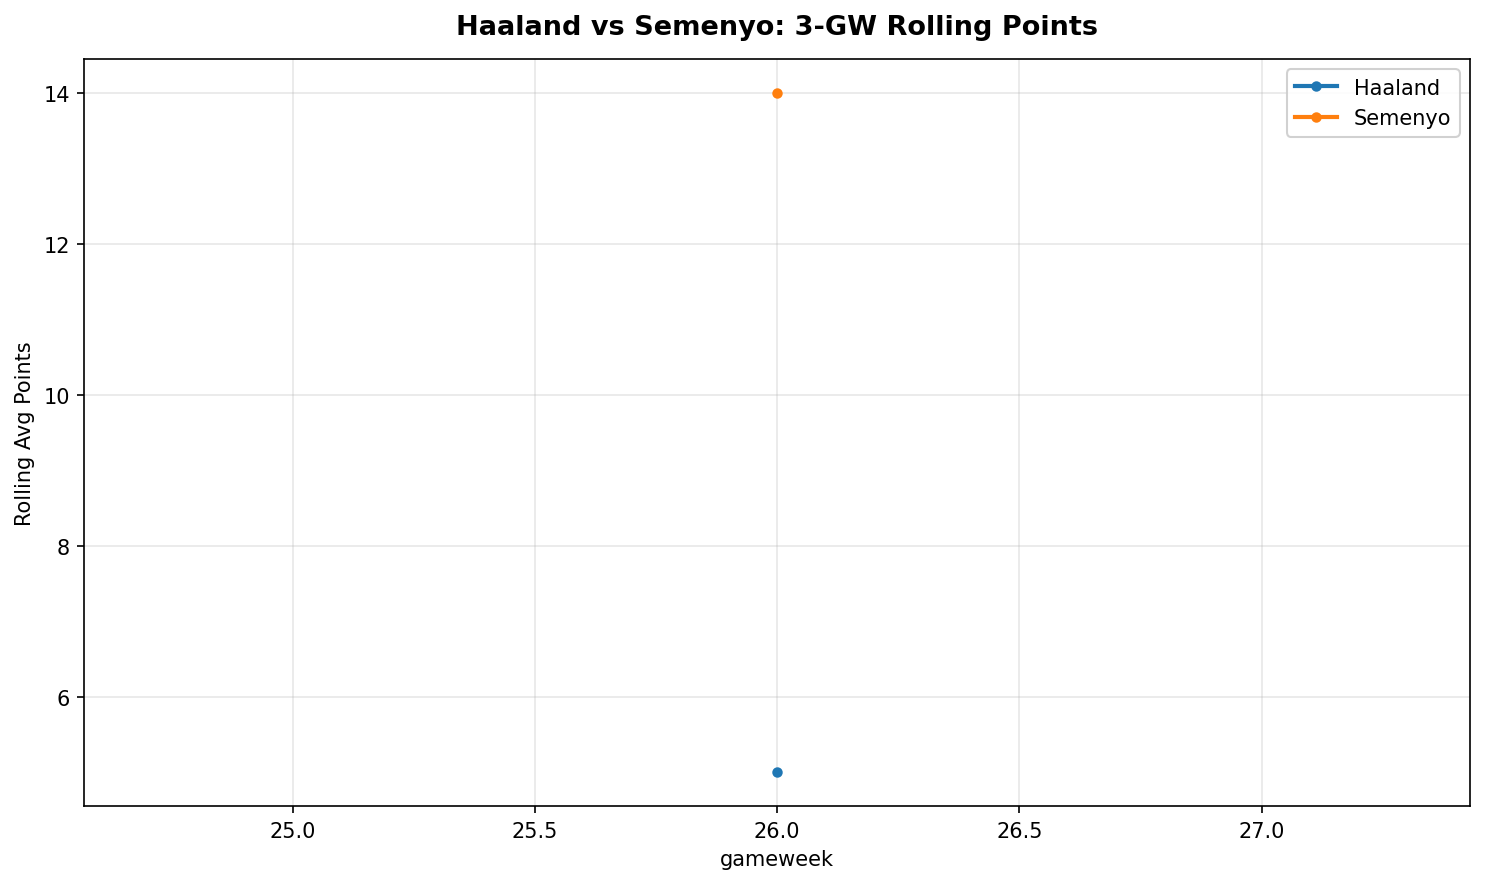

In [9]:
# Fetch player gameweek data for top 2 players
if len(df_players) >= 2:
    top_2_ids = df_players.head(2)['id'].tolist()
    top_2_names = df_players.head(2)['web_name'].tolist()
    print(f'Comparing: {top_2_names[0]} vs {top_2_names[1]}')
    
    df_pgw = fetch_df(QuerySpec(
        table='player_gameweeks',
        filters=[Filter('player_id', 'in', top_2_ids)],
        order_by='gameweek',
        limit=50,
    ))
    
    # Merge with player names
    name_map = dict(zip(df_players['id'], df_players['web_name']))
    df_pgw['player_name'] = df_pgw['player_id'].map(name_map)
    
    # Add rolling mean
    df_pgw = add_rolling_mean(df_pgw, 'total_points', window=3, group_by='player_id')
    
    # Plot
    chart_path = render_line(
        df_pgw, x='gameweek', y='total_points_rolling_3', hue='player_name',
        title=f'{top_2_names[0]} vs {top_2_names[1]}: 3-GW Rolling Points',
        ylabel='Rolling Avg Points',
    )
    display(Image(filename=str(chart_path)))
else:
    print('Not enough players to compare')

## 5c. Fixture Difficulty Heatmap

Fetched 100 upcoming fixtures


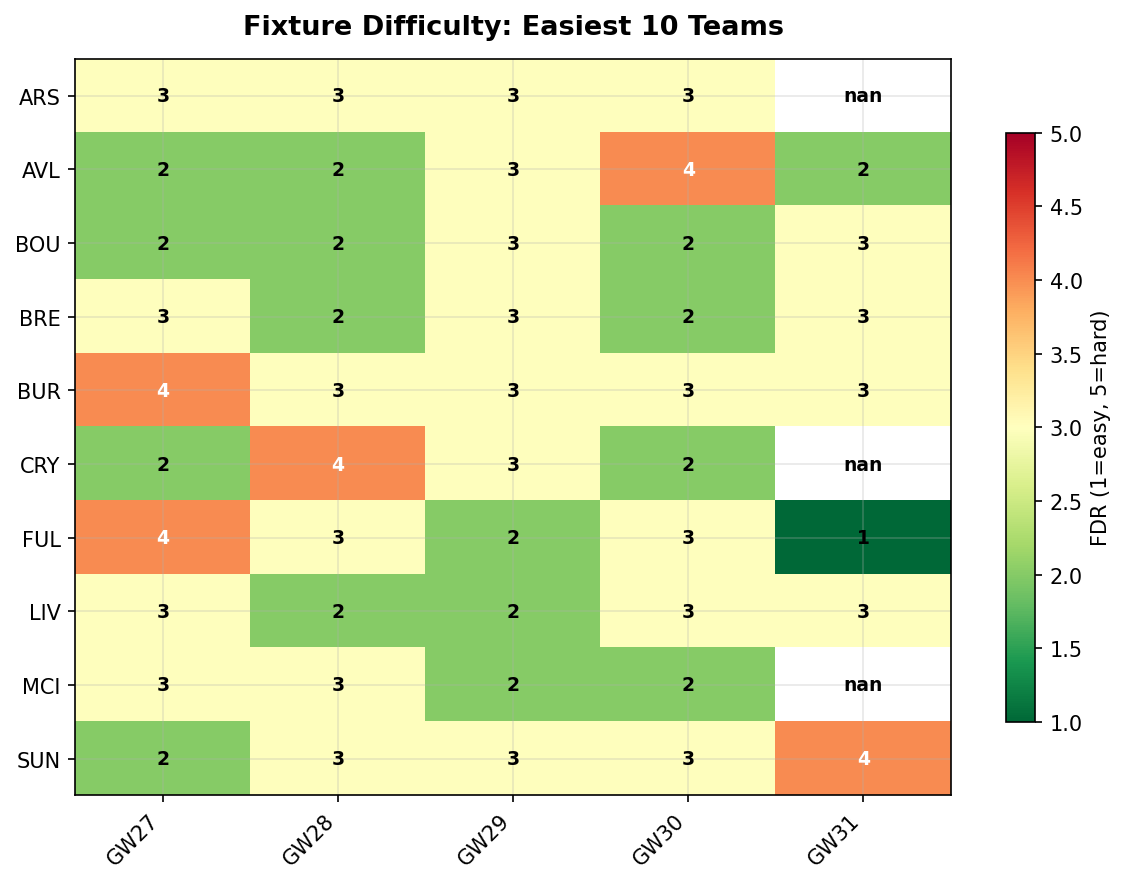

In [10]:
# Fetch fixtures
df_fixtures = fetch_enriched(
    'fixtures',
    filters=[Filter('finished', 'eq', False)],
    order_by='gameweek',
    limit=100,
)
print(f'Fetched {len(df_fixtures)} upcoming fixtures')

if not df_fixtures.empty and 'home_team' in df_fixtures.columns:
    # Build FDR grid: for each team, FDR per gameweek
    rows = []
    for _, fix in df_fixtures.iterrows():
        gw = fix.get('gameweek')
        if pd.isna(gw):
            continue
        rows.append({'team': fix['home_team'], 'gameweek': int(gw), 'fdr': fix.get('home_difficulty', 3)})
        rows.append({'team': fix['away_team'], 'gameweek': int(gw), 'fdr': fix.get('away_difficulty', 3)})
    
    fdr_df = pd.DataFrame(rows)
    # Take first 5 GWs, top 10 teams by avg FDR (easiest)
    gws = sorted(fdr_df['gameweek'].unique())[:5]
    fdr_window = fdr_df[fdr_df['gameweek'].isin(gws)]
    avg_fdr = fdr_window.groupby('team')['fdr'].mean().nsmallest(10)
    top_teams = avg_fdr.index.tolist()
    
    pivot = fdr_window[fdr_window['team'].isin(top_teams)].pivot_table(
        index='team', columns='gameweek', values='fdr', aggfunc='first'
    )
    pivot.columns = [f'GW{int(c)}' for c in pivot.columns]
    
    chart_path = render_heatmap(pivot, title='Fixture Difficulty: Easiest 10 Teams')
    display(Image(filename=str(chart_path)))
else:
    print('No fixture data available or enrichment missing team names')

## 6. Executor — Simulate LLM Code Execution

In [11]:
# Simulate what an LLM would generate in an ANALYZE step
llm_code = '''
# Rank players by points-per-million
df = df_players.copy()
df['pts_per_m'] = df['total_points'] / df['price']
top_value = rank_by(df, 'pts_per_m', n=10)
print('Top 10 by Value (pts/million):')
for _, row in top_value.iterrows():
    print(f"  {row['rank']}. {row['web_name']} — {row['pts_per_m']:.1f} pts/m (£{row['price']}m, {row['total_points']} pts)")
'''

result = execute(llm_code, context={'df_players': df_players})

if result.error:
    print(f'ERROR: {result.error}')
else:
    print(result.stdout)
    print(f'\nExecution time: {result.duration_ms}ms')
    print(f'DataFrames produced: {list(result.dataframes.keys())}')
    print(f'Charts produced: {len(result.charts)}')

Top 10 by Value (pts/million):
  1. Mukiele — 24.8 pts/m (£4.6m, 114 pts)
  2. Guéhi — 23.8 pts/m (£5.2m, 124 pts)
  3. Lacroix — 22.7 pts/m (£5.1m, 116 pts)
  4. Chalobah — 21.4 pts/m (£5.8m, 124 pts)
  5. Matheus N. — 21.3 pts/m (£5.4m, 115 pts)
  6. Tarkowski — 20.5 pts/m (£5.7m, 117 pts)
  7. Gabriel — 20.0 pts/m (£7.1m, 142 pts)
  8. Wilson — 20.0 pts/m (£6.0m, 120 pts)
  9. Rice — 19.5 pts/m (£7.6m, 148 pts)
  10. J.Timber — 19.4 pts/m (£6.4m, 124 pts)


Execution time: 3ms
DataFrames produced: ['df', 'top_value']
Charts produced: 0


## 7. Executor with Chart — Full Loop

Chart saved: C:\Users\vigne\AppData\Local\Temp\fpl_exec_yfpprk_a\bar.png



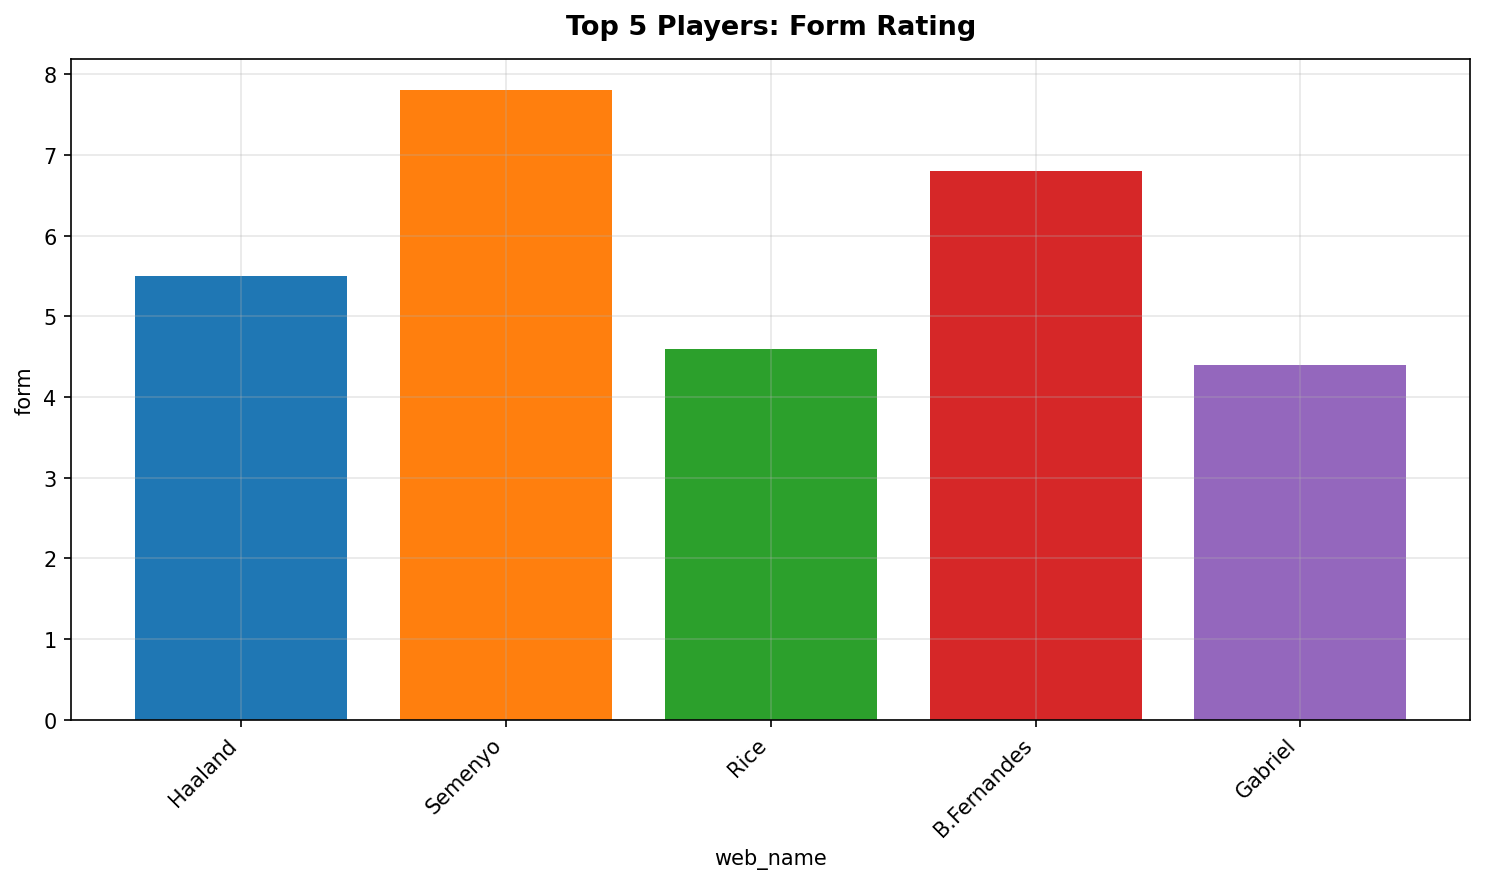

In [12]:
# Simulate full ANALYZE + GENERATE flow
analyze_code = '''
# Compare top 5 players: form vs price
top5 = rank_by(df_players, 'total_points', n=5)
chart = render_bar(df=top5, x='web_name', y='form', title='Top 5 Players: Form Rating')
print(f'Chart saved: {chart}')
'''

result = execute(analyze_code, context={'df_players': df_players})

if result.error:
    print(f'ERROR: {result.error}')
else:
    print(result.stdout)
    for chart_path in result.charts:
        display(Image(filename=str(chart_path)))

## 8. Safety — Blocked Operations

In [13]:
# Verify sandbox blocks unsafe operations
for bad_code, label in [
    ('import os', 'import os'),
    ('open("/etc/passwd")', 'open file'),
    ('__import__("subprocess")', '__import__'),
]:
    r = execute(bad_code)
    status = 'BLOCKED' if r.error else 'ALLOWED (!!)'
    print(f'  {status}: {label} — {r.error or "no error"}')

  BLOCKED: import os — Traceback (most recent call last):
    exec(compiled, safe_globals, safe_locals)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<llm_code>", line 1, in <module>
    raise ImportError(
    ...<2 lines>...
    )
ImportError: Import of 'os' is not allowed in the sandbox. Available modules: pandas (pd), numpy (np), and FPL BI functions.
  BLOCKED: open file — Traceback (most recent call last):
    exec(compiled, safe_globals, safe_locals)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<llm_code>", line 1, in <module>
    raise RuntimeError(f"'{name}' is not allowed in the sandbox.")
RuntimeError: 'open' is not allowed in the sandbox.
  BLOCKED: __import__ — Traceback (most recent call last):
    exec(compiled, safe_globals, safe_locals)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<llm_code>", line 1, in <module>
    raise ImportError(
    ...<2 lines>...
    )
ImportError: Import of 'subprocess' is not allowed in the sandbox. Available modules